Getting Started with FCN Pre-trained Models
==============================================

This is a quick demo of using GluonCV FCN model.
Please follow the `installation guide <../index.html>`_ to install MXNet and GluonCV if not yet.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import random, multiprocessing, time

import mxnet as mx
from mxnet import image
from mxnet.gluon.data.vision import transforms
from mxnet import gluon, autograd
from mxnet.gluon import nn

from mxboard import SummaryWriter

import numpy as np

import gluoncv
from gluoncv.utils.parallel import *
from gluoncv.utils.viz import get_color_pallete, DeNormalize

Train FCN on Pascal VOC Dataset
==================================

The PASCAL Visual Object Classes 
http://host.robots.ox.ac.uk/pascal/VOC/
20 classes


Multi-Scale Context Aggregation by Dilated Convolutions, Fisher Yu, Vladlen Koltun, ICLR2016

![](https://github.com/aleju/papers/raw/master/neural-nets/images/Multi-Scale_Context_Aggregation_by_Dilated_Convolutions__receptive.png?raw=true)

State-of-the-art approaches of semantic segmentation are typically based on
Fully Convolutional Network (FCN) [Long15]_.
The key idea of a fully convolutional network is that it is "fully convolutional",
which means it does have any fully connected layers. Therefore, the network can
accept arbitrary input size and make dense per-pixel predictions.
Base/Encoder network is typically pre-trained on ImageNet, because the features
learned from diverse set of images contain rich contextual information, which
can be beneficial for semantic segmentation.

Model Dilation
--------------


Visualization of dilated/atrous convolution


![](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/dilation.gif)

figure credit to [conv_arithmetic](https://github.com/vdumoulin/conv_arithmetic)


FCN Model
---------


In [2]:
nclasses = len(gluoncv.data.VOCSegmentation().classes)

In [3]:
class FCN(nn.HybridBlock):
    def __init__(self, resnet_backbone, nclass):
        super(FCN, self).__init__()
        self.backbone = resnet_backbone 
        in_channels = 2048
        with self.name_scope():
            self.head = nn.HybridSequential()
            inter_channels = in_channels // 4
            self.head.add(nn.Conv2D(in_channels=in_channels, channels=inter_channels,
                                     kernel_size=3, padding=1))
            self.head.add(nn.BatchNorm(in_channels=inter_channels))
            self.head.add(nn.Activation('relu'))
            self.head.add(nn.Dropout(0.1))
            self.head.add(nn.Conv2D(in_channels=inter_channels, channels=nclass,
                                     kernel_size=1))
        
    def hybrid_forward(self, F, x):
        # run through backbone
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        c3 = self.backbone.layer3(x)
        c4 = self.backbone.layer4(c3)

        #run through head
        y = self.head(c4)

        #resize
        y = F.contrib.BilinearResize2D(y, height=480,width=480)
        return y

In [4]:
ctx_list = [mx.gpu(i) for i in range(4)]
backbone = gluoncv.model_zoo.resnet50_v1b(pretrained=True, dilated=True, ctx=ctx_list)
del backbone.fc

net = FCN(backbone, nclasses)

# Initialize the head
net.head.collect_params().setattr('lr_mult', 10)
net.head.initialize(mx.init.Xavier(), ctx=ctx_list)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/mxnet/gluon/block.py:415: UserWarning: load_params is deprecated. Please use load_parameters.
  warnings.warn("load_params is deprecated. Please use load_parameters.")


Dataset and Data Augmentation
-----------------------------

image transform for color normalization



In [5]:
input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225]),
])

We provide semantic segmentation datasets in :class:`gluoncv.data`.
For example, we can easily get the Pascal VOC 2012 dataset:



In [6]:
trainset = gluoncv.data.VOCSegmentation(split='train', transform=input_transform)
print(len(trainset))
valset = gluoncv.data.VOCSegmentation(split='val', transform=input_transform)
print(len(valset))

2913
1449


In [7]:
batch_size = 32
# Create Training Loader
train_data = gluon.data.DataLoader(trainset, batch_size, shuffle=True, last_batch='rollover', 
                                   num_workers=multiprocessing.cpu_count()-5)
val_data = gluon.data.DataLoader(valset, batch_size, shuffle=False, last_batch='discard', 
                                   num_workers=multiprocessing.cpu_count()-5)

For data augmentation,
we follow the standard data augmentation routine to transform the input image
and the ground truth label map synchronously. (*Note that "nearest"
mode upsample are applied to the label maps to avoid messing up the boundaries.*)
We first randomly scale the input image from 0.5 to 2.0 times, then rotate
the image from -10 to 10 degrees, and crop the image with padding if needed.
Finally a random Gaussian blurring is applied.

Random pick one example for visualization:



In [8]:
idx = random.randint(0, len(trainset))
img, mask = trainset[idx]

mask = get_color_pallete(mask.asnumpy(), dataset='pascal_voc')
mask = np.array(mask.convert('RGB'), dtype=np.int)

# denormalize the image
img = DeNormalize([-.485, -.456, -.406], [.229, .224, .225])(img)
img = np.transpose((img.asnumpy()*255).astype(np.uint8), (1, 2, 0))

Plot the image and mask



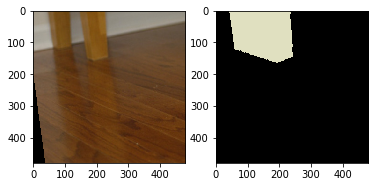

In [9]:
# subplot 1 for img
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(img)

# subplot 2 for the mask
fig.add_subplot(1,2,2)
plt.imshow(mask)

# display
plt.show()

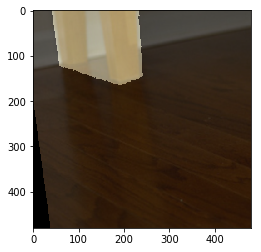

In [10]:
plt.imshow(((mask+img)/2).astype(int))

Training Details
----------------

- Training Losses:

    We apply a standard per-pixel Softmax Cross Entropy Loss to train FCN. For Pascal
    VOC dataset, we ignore the loss from boundary class (number 22).
    Additionally, an Auxiliary Loss as in PSPNet [Zhao17]_ at Stage 3 can be enabled when
    training with command ``--aux``. This will create an additional FCN "head" after Stage 3.

In [11]:
from gluoncv.model_zoo.segbase import SoftmaxCrossEntropyLossWithAux
criterion = SoftmaxCrossEntropyLossWithAux(aux=False)

Learning Rate and Scheduling:
- head is 10x LR compared to backbone
- LR PolyLR schedule


We use different learning rate for FCN "head" and the base network. For the FCN "head",
we use $10\times$ base learning rate, because those layers are learned from scratch.
We use a poly-like learning rate scheduler for FCN training, provided in :class:`gluoncv.utils.PolyLRScheduler`.
The learning rate is given by $lr = baselr \times (1-iter)^{power}$

In [12]:
epochs = 50

- Dataparallel for multi-gpu training



In [13]:
model = DataParallelModel(net, ctx_list)
criterion = DataParallelCriterion(criterion, ctx_list)

- Learning rate finder (
Cyclical Learning Rates for Training Neural Networks, Leslie N. Smith, 2015)
- Learning rate schedule

![](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/lr_finder/finder_plot.png)

In [14]:
lr_scheduler = gluoncv.utils.LRScheduler('step', 
                                         0.001*len(ctx_list), 
                                         len(train_data), 
                                         epochs, 
                                         step=(10,30,40), 
                                         warmup_epochs=2, 
                                         warmup_lr=0.001)

- Create SGD solver



In [15]:
optimizer = gluon.Trainer(model.module.collect_params(), 'sgd',
                          {'lr_scheduler': lr_scheduler,
                           'wd':0.0001,
                           'momentum': 0.95,
                           'multi_precision': True})

The training loop
-----------------




In [16]:
def get_images(outputs, data, target):
    outputs_images = outputs[0][0].argmax(1).asnumpy()
    outputs_images = [get_color_pallete(mask, dataset='pascal_voc') for mask in outputs_images]
    outputs_images = [np.expand_dims(np.array(mask.convert('RGB'), dtype=np.int), 0) for mask in outputs_images]
    outputs_images = np.concatenate(outputs_images)[:3]
    outputs_images = outputs_images.transpose((0, 3, 1, 2)).astype(np.uint8)

    target_images = target[:3,:,:]
    target_images = [get_color_pallete(mask.asnumpy(), dataset='pascal_voc') for mask in target_images]
    target_images = [np.expand_dims(np.array(mask.convert('RGB'), dtype=np.int), 0) for mask in target_images]
    target_images = np.concatenate(target_images).transpose((0, 3, 1, 2)).astype(np.uint8)

    data_images = data[:3,:,:,:]
    data_images = DeNormalize([-.485, -.456, -.406], [.229, .224, .225])(data_images)
    data_images = (data_images.asnumpy()*255).astype(np.uint8).astype(np.uint8)
    
    return outputs_images, target_images, data_images

In [ ]:
n_batch = 5
train_loss = 0.0
for e in range(epochs):
    tick = time.time()
    train_loss = 0
    
    # Train
    for i, (data, target) in enumerate(train_data):
        lr_scheduler.update(i, e)
        with autograd.record(True):
            outputs = model(data)
            losses = criterion(outputs, target)
            autograd.backward(losses)
        optimizer.step(batch_size, ignore_stale_grad=True)        
        
        if i % 10 == 0:
            for loss in losses:
                train_loss += loss.mean().asnumpy() / len(losses)
    
    # Val
    val_loss = 0
    for j, (data, target) in enumerate(val_data):
        outputs = model(data)
        losses = criterion(outputs, target)
        for loss in losses:
            val_loss += loss.mean().asnumpy() / len(losses)

            
    print("Epoch[{}]|Time {:.2f}s|Batch[{}]|Train Loss:{:.2f}|Val Loss:{:.2f}".format(
        e, time.time()-tick, i, train_loss[0]/(i+1), val_loss[0]/(j+1))
         )                                                          
                                                          
    # print images
    pred_images, target_images, data_images = get_images(outputs, data, target)
    with SummaryWriter(logdir='/data/logs/run1') as sw:
        sw.add_image(tag='data_image', image=data_images, global_step=e)
        sw.add_image(tag='pred_image', image=(pred_images*0.7+0.3*data_images).astype(np.uint8), global_step=e)
        sw.add_image(tag='target_image', image=(target_images*0.7+0.3*data_images).astype(np.uint8), global_step=e)
        sw.add_scalar(tag='loss', value={'test':val_loss[0]/(j+1)}, global_step=e)
        sw.add_scalar(tag='loss', value={'train':train_loss[0]/(i+1)}, global_step=e)


References
----------

.. [Long15] Long, Jonathan, Evan Shelhamer, and Trevor Darrell. \
    "Fully convolutional networks for semantic segmentation." \
    Proceedings of the IEEE conference on computer vision and pattern recognition. 2015.

.. [Zhao17] Zhao, Hengshuang, Jianping Shi, Xiaojuan Qi, Xiaogang Wang, and Jiaya Jia. \
    "Pyramid scene parsing network." IEEE Conf. on Computer Vision and Pattern Recognition (CVPR). 2017.


